# Comparación de PHL con otros métodos de selección de instancias

In [27]:
import pandas as pd
import numpy as np
import time
import os
import sys

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import f1_score, accuracy_score

from data_reduction.representativeness import find_epsilon

sys.path.append('../')
from my_dataset_reduction import phl_selection, srs_selection, clc_selection, drop3_selection, cnn_selection

import seaborn as sns
import matplotlib.pyplot as plt

# Set path to the notebook directory (Jupyter compatible)

dbnames = ['pima',
           'drybeans',
           'diabetes_binary_5050split',
           'diabetes_binary'
]

dbpaths = ['../datasets/pima.csv',
           '../datasets/dry+bean+dataset/DryBeanDataset/Dry_Bean_Dataset.xlsx',
           '../datasets/diabetes_health_indicators/diabetes_binary_5050split_health_indicators_BRFSS2015.csv',
           '../datasets/diabetes_health_indicators/diabetes_binary_health_indicators_BRFSS2015.csv'
]
targets = ['Outcome',
          'Class',
          'Diabetes_binary',
          'Diabetes_binary']

results_folders = ['../results/pima/',
                '../results/drybeans/',
                '../results/diabetes_binary_5050split/',
                '../results/diabetes_binary/']

In [28]:
def read_dataset(dbpath):
    if not os.path.exists(dbpath):
        print(f"{dbpath} does not exist.")
        return pd.DataFrame()

    # Load the dataset
    if dbpath.endswith('.xlsx') or dbpath.endswith('.xls'):
        # Read the Excel file
        df = pd.read_excel(dbpath, )
    else:
        # Read the CSV file
        df = pd.read_csv(dbpath)
    return df

dfs = [read_dataset(dbpath) for dbpath in dbpaths]
print("Tamaños de los datasets:")
for dbname, df in zip(dbnames, dfs):
    print(f"{dbname}: {df.shape}")

Tamaños de los datasets:
pima: (768, 9)
drybeans: (13611, 17)
diabetes_binary_5050split: (70692, 22)
diabetes_binary: (253680, 22)


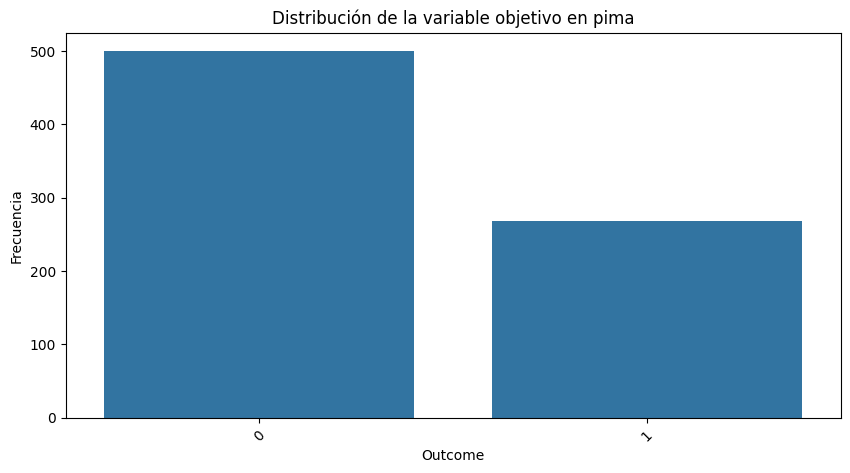

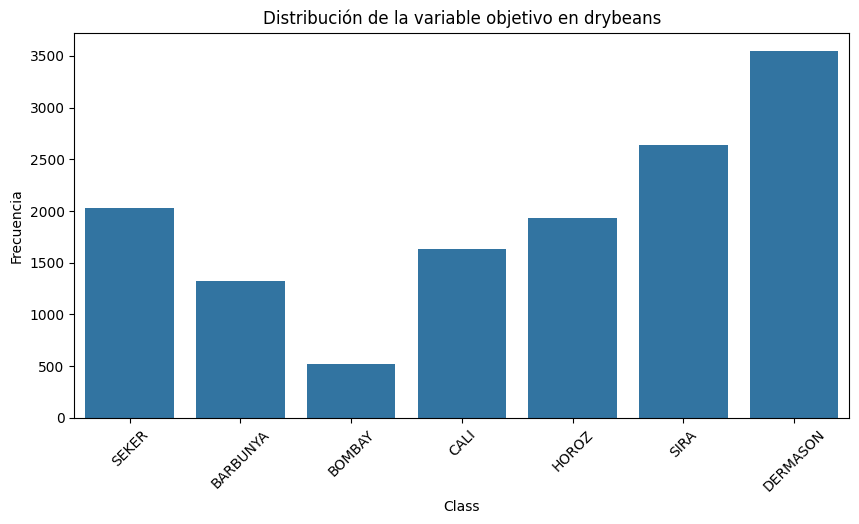

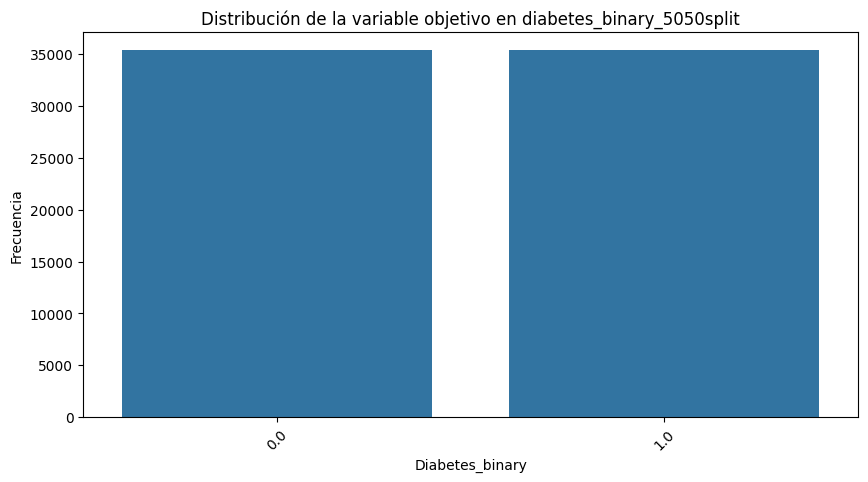

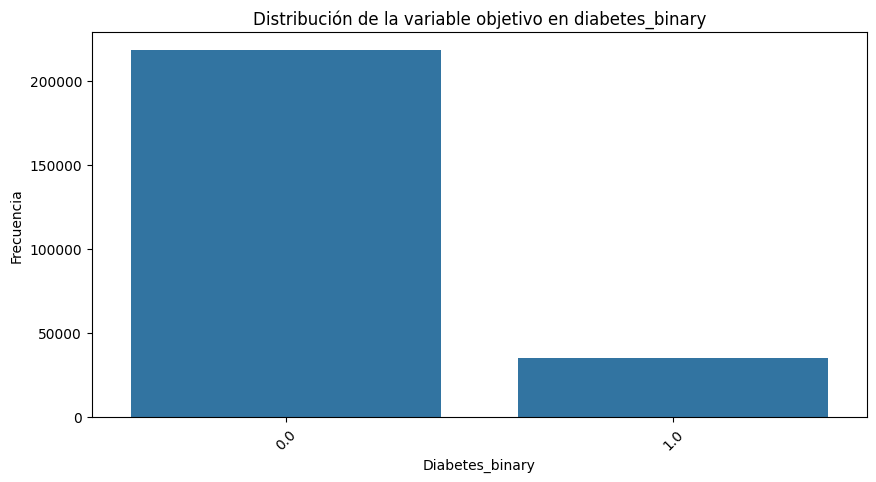

In [29]:
# Show bar plot of the target variable
for dbname, df, target in zip(dbnames, dfs, targets):
    plt.figure(figsize=(10, 5))
    sns.countplot(x=target, data=df)
    plt.title(f'Distribución de la variable objetivo en {dbname}')
    plt.xlabel(target)
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45)
    plt.show()

## Comparación de métodos de selección de instancias

In [30]:
# import warnings
# warnings.filterwarnings("ignore", category=FutureWarning)
df_results = dict()
for dbname, results_folder in zip(dbnames, results_folders):
    df_results[dbname] = pd.read_csv(results_folder + 'results.csv')

### Dataset PIMA

In [31]:
results = df_results['pima']
results_folder = results_folders[0]
results

,model,reduction_method,percentage,reduction_ratio,representativeness,accuracy,f1,training_time,reduction_time
0,KNN,None,1.00,1.000000,0.000000,0.714286,0.709411,0.001055,0.000000
1,RF,None,1.00,1.000000,0.000000,0.720779,0.714025,0.113521,0.000000
2,XGB,None,1.00,1.000000,0.000000,0.753247,0.751855,0.064991,0.000000
3,KNN,SRS,0.05,0.048860,4.854175,0.681818,0.657571,0.000441,0.000648
4,KNN,SRS,0.10,0.097720,4.804304,0.655844,0.642750,0.000447,0.000634
...,...,...,...,...,...,...,...,...,...
109,RF,PHL_R1_k=3,0.75,0.750814,2.956791,0.733766,0.732678,0.096607,0.130923
110,XGB,PHL_R1_k=3,0.75,0.750814,2.956791,0.759740,0.760521,0.034468,0.130923
111,KNN,PHL_R1_k=3,0.90,0.899023,3.305408,0.727273,0.724807,0.000747,0.130934
112,RF,PHL_R1_k=3,0.90,0.899023,3.305408,0.785714,0.781572,0.105000,0.130934


/tmp/ipykernel_10584/2911810448.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_results = results.groupby(['reduction_method', 'percentage'])['representativeness', 'reduction_ratio', 'reduction_time'].mean().reset_index()


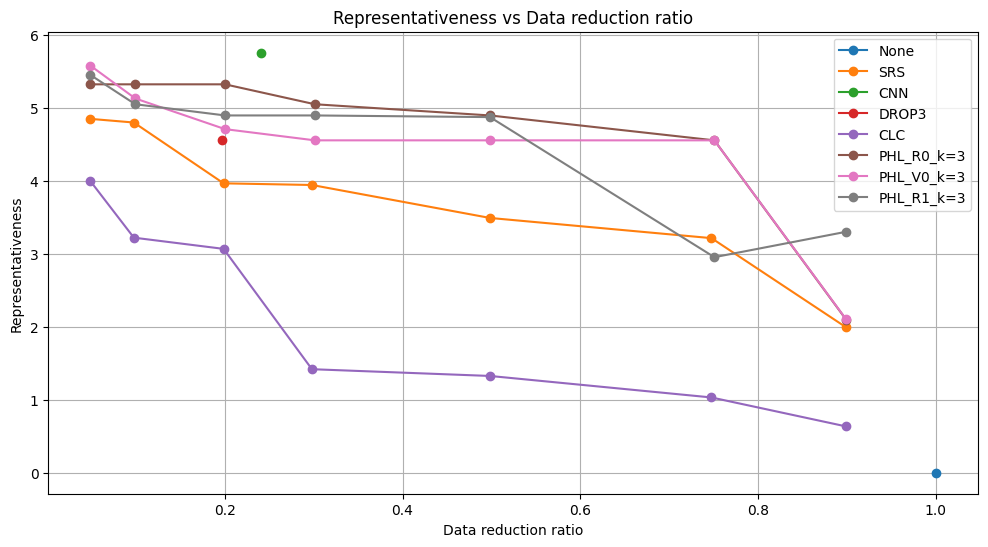

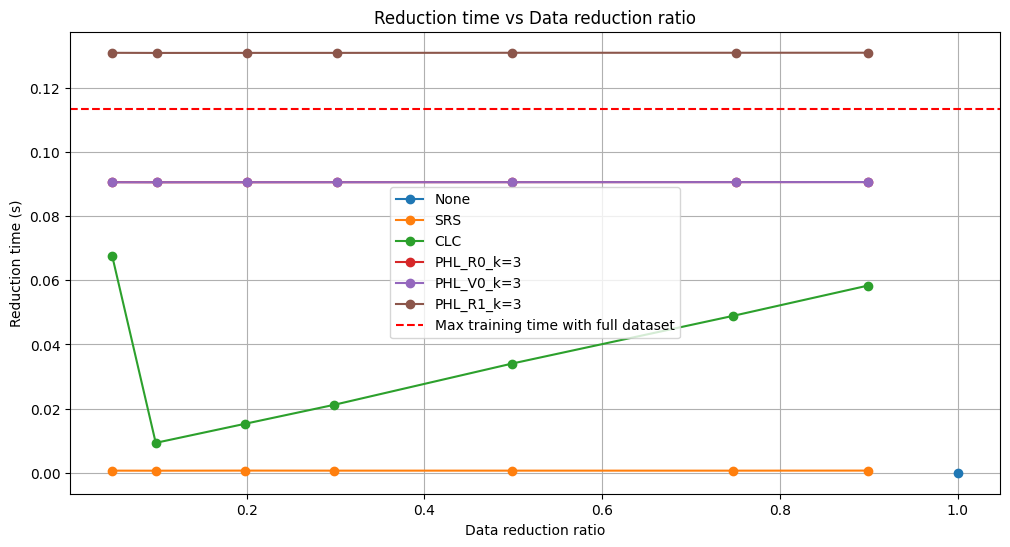

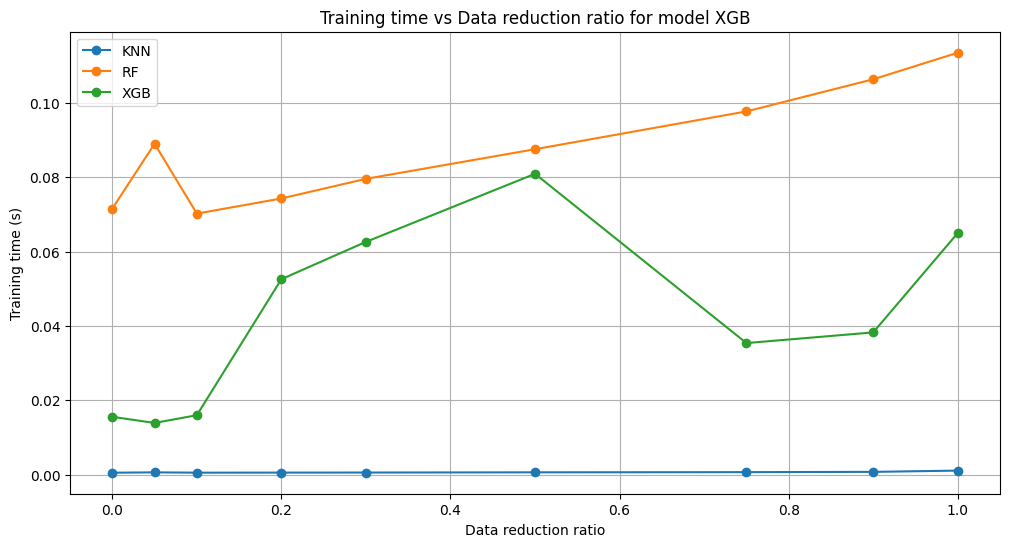

In [32]:
def plot_representativeness():
    mean_results = results.groupby(['reduction_method', 'percentage'])['representativeness', 'reduction_ratio', 'reduction_time'].mean().reset_index()
    mean_training_time = results.groupby(['model', 'percentage'])['training_time'].mean().reset_index()

    # Plot representativeness vs percentage averaged by model
    plt.figure(figsize=(12, 6))
    for reduction_method in results['reduction_method'].unique():
        plt.plot(mean_results[mean_results['reduction_method'] == reduction_method]['reduction_ratio'],
                mean_results[mean_results['reduction_method'] == reduction_method]['representativeness'],
                label=reduction_method, marker='o')
    plt.title(f'Representativeness vs Data reduction ratio')
    plt.xlabel('Data reduction ratio')
    plt.ylabel('Representativeness')
    plt.legend()
    plt.grid()
    # plt.savefig(f'{results_folder}/representativeness_vs_reduction_ratio.png')
    plt.show()

    # Plot reduction time vs percentage averaged by model
    plt.figure(figsize=(12, 6))
    for reduction_method in results['reduction_method'].unique():
        if reduction_method not in ['DROP3', 'CNN']:
            plt.plot(mean_results[mean_results['reduction_method'] == reduction_method]['reduction_ratio'],
                    mean_results[mean_results['reduction_method'] == reduction_method]['reduction_time'],
                    label=reduction_method, marker='o')
    plt.axhline(y=mean_training_time['training_time'].max(), color='r', linestyle='--', label='Max training time with full dataset')
    plt.title(f'Reduction time vs Data reduction ratio')
    plt.xlabel('Data reduction ratio')
    plt.ylabel('Reduction time (s)')
    plt.legend()
    plt.grid()
    # plt.savefig(f'{results_folder}/reduction_time_vs_reduction_ratio.png')
    plt.show()

    # Plot training time vs percentage averaged by reduction method
    plt.figure(figsize=(12, 6))
    mean_training_time
    for model_name in results['model'].unique():
        plt.plot(mean_training_time[mean_training_time['model'] == model_name]['percentage'],
                mean_training_time[mean_training_time['model'] == model_name]['training_time'],
                label=model_name, marker='o')
    plt.title(f'Training time vs Data reduction ratio for model {model_name}')
    plt.xlabel('Data reduction ratio')
    plt.ylabel('Training time (s)')
    plt.legend()
    plt.grid()
    # plt.savefig(f'{results_folder}/training_time_vs_percentage.png')
    plt.show()

plot_representativeness()

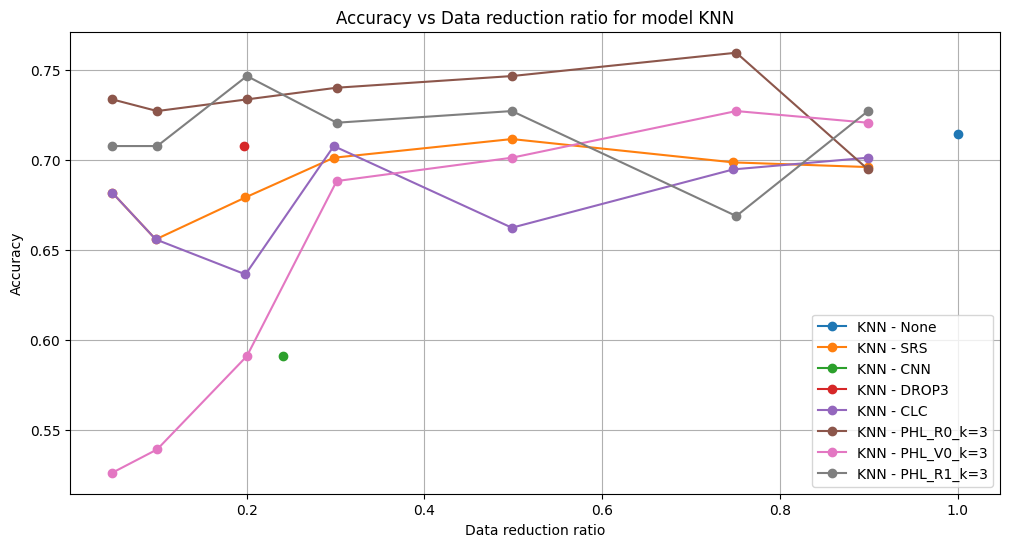

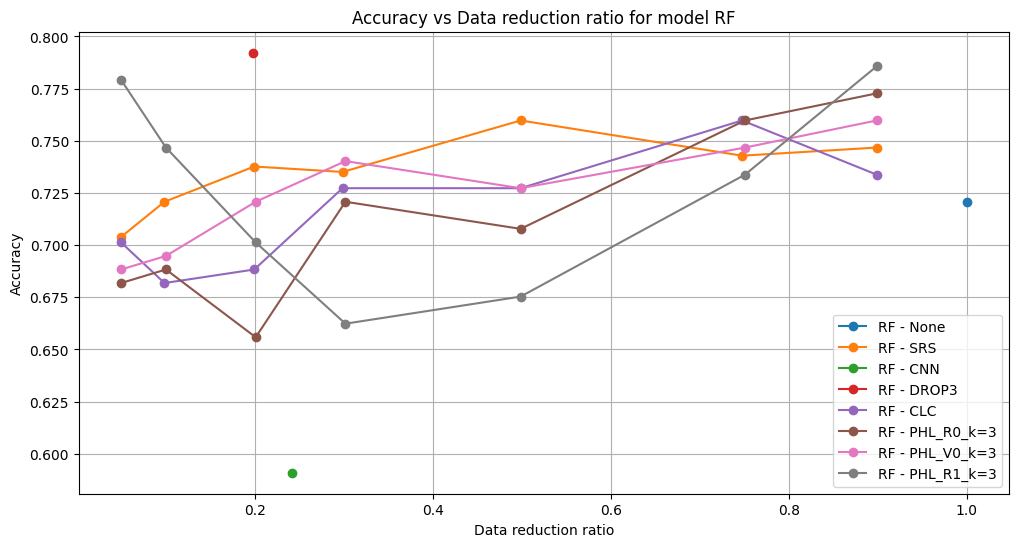

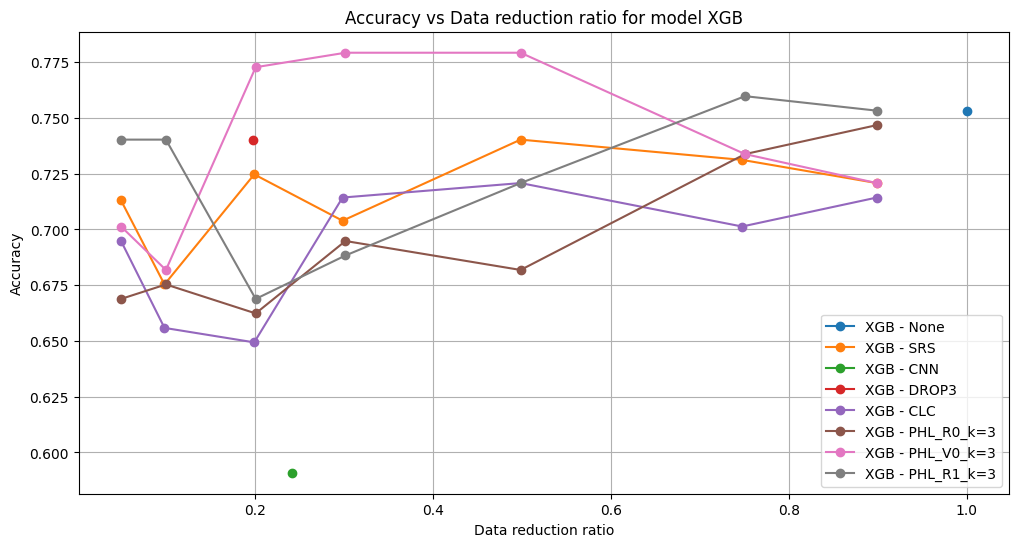

In [33]:
def plot_accuracy():
    for model_name in results['model'].unique():
        plt.figure(figsize=(12, 6))
        for reduction_method in results['reduction_method'].unique():
            # if reduction_method not in ['CNN', 'PHL_R1_k=3']:
                plt.plot(results[(results['model'] == model_name) & (results['reduction_method'] == reduction_method)]['reduction_ratio'],
                        results[(results['model'] == model_name) & (results['reduction_method'] == reduction_method)]['accuracy'],
                        label=f'{model_name} - {reduction_method}', marker='o')
        plt.title(f'Accuracy vs Data reduction ratio for model {model_name}')
        plt.xlabel('Data reduction ratio')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid()
        # plt.savefig(f'{results_folder}/accuracy_vs_percentage_{model_name}.png')
        plt.show()
        
plot_accuracy()

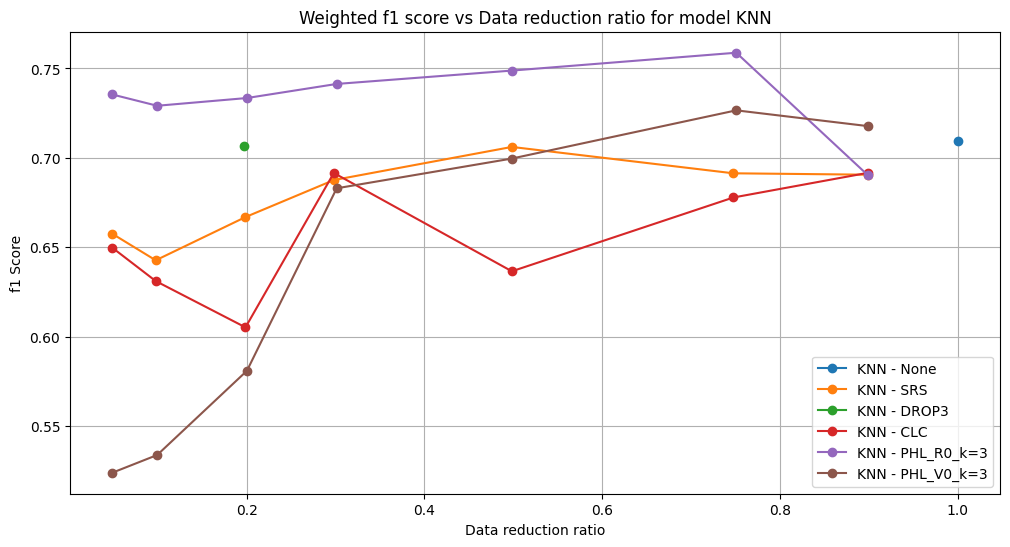

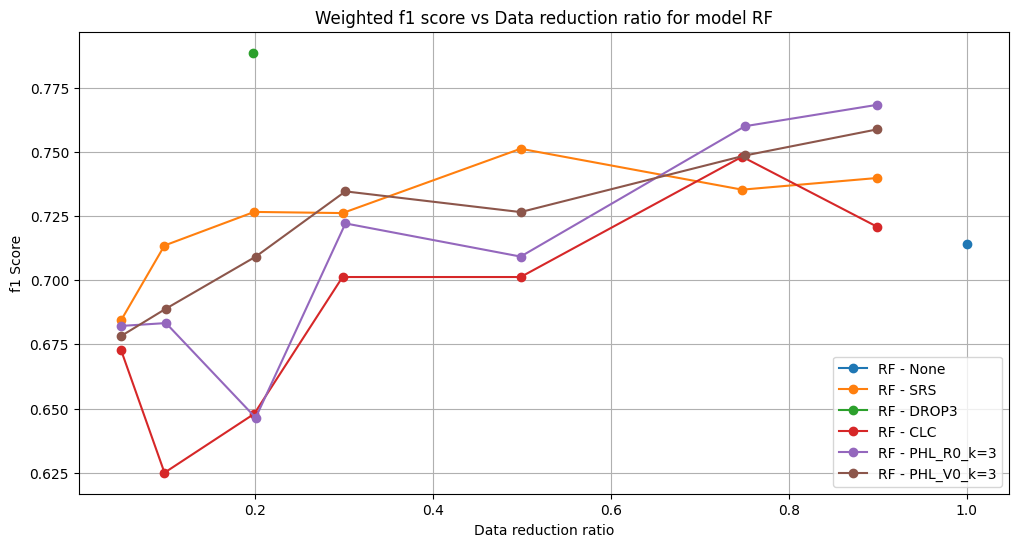

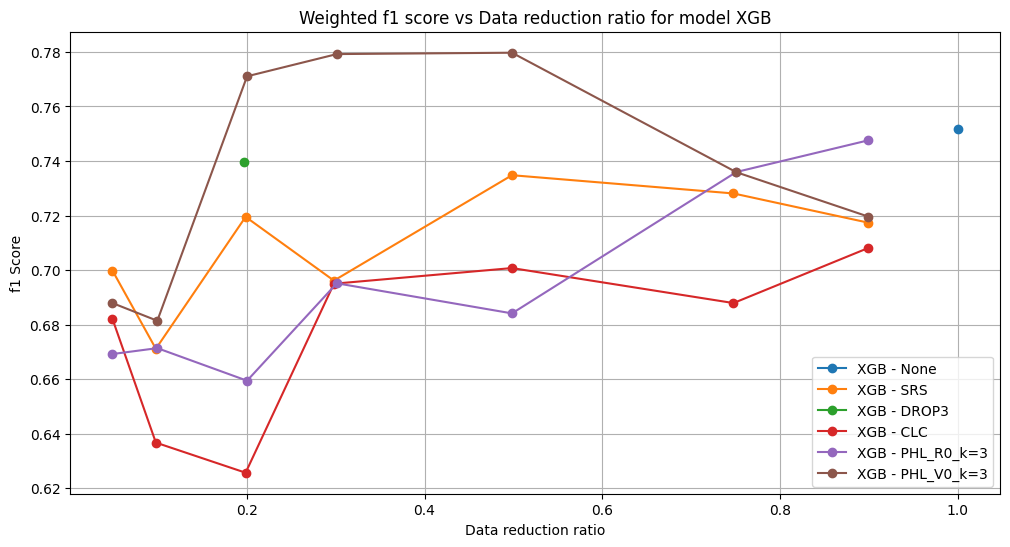

In [34]:
def plot_f1():
    for model_name in results['model'].unique():
        plt.figure(figsize=(12, 6))
        for reduction_method in results['reduction_method'].unique():
            if reduction_method not in ['CNN', 'PHL_R1_k=3']:
                plt.plot(results[(results['model'] == model_name) & (results['reduction_method'] == reduction_method)]['reduction_ratio'],
                        results[(results['model'] == model_name) & (results['reduction_method'] == reduction_method)]['f1'],
                        label=f'{model_name} - {reduction_method}', marker='o')
        plt.title(f'Weighted f1 score vs Data reduction ratio for model {model_name}')
        plt.xlabel('Data reduction ratio')
        plt.ylabel('f1 Score')
        plt.legend()
        plt.grid()
        # plt.savefig(f'{results_folder}/f1_vs_reduction_ratio_{model_name}.png')
        plt.show()

plot_f1()

### Dataset DryBeans

In [35]:
results = df_results['drybeans']
results_folder = results_folder[1]
results

,model,reduction_method,percentage,reduction_ratio,representativeness,accuracy,f1,training_time,reduction_time
0,KNN,None,1.00,1.000000,0.000000,0.918840,0.919008,0.001121,0.000000
1,RF,None,1.00,1.000000,0.000000,0.922879,0.922812,3.371022,0.000000
2,XGB,None,1.00,1.000000,0.000000,0.920676,0.920778,0.531868,0.000000
3,KNN,SRS,0.05,0.049596,13.460832,0.899008,0.899391,0.000369,0.003635
4,KNN,SRS,0.10,0.099743,10.810566,0.902167,0.902509,0.000390,0.003608
...,...,...,...,...,...,...,...,...,...
109,RF,PHL_R1_k=3,0.75,0.750000,12.640035,0.921043,0.921281,2.265294,2.449526
110,XGB,PHL_R1_k=3,0.75,0.750000,12.640035,0.920676,0.921078,0.447789,2.449526
111,KNN,PHL_R1_k=3,0.90,0.900073,10.841108,0.919207,0.919445,0.000836,2.449873
112,RF,PHL_R1_k=3,0.90,0.900073,10.841108,0.923981,0.923930,2.897516,2.449873


/tmp/ipykernel_10584/2911810448.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_results = results.groupby(['reduction_method', 'percentage'])['representativeness', 'reduction_ratio', 'reduction_time'].mean().reset_index()


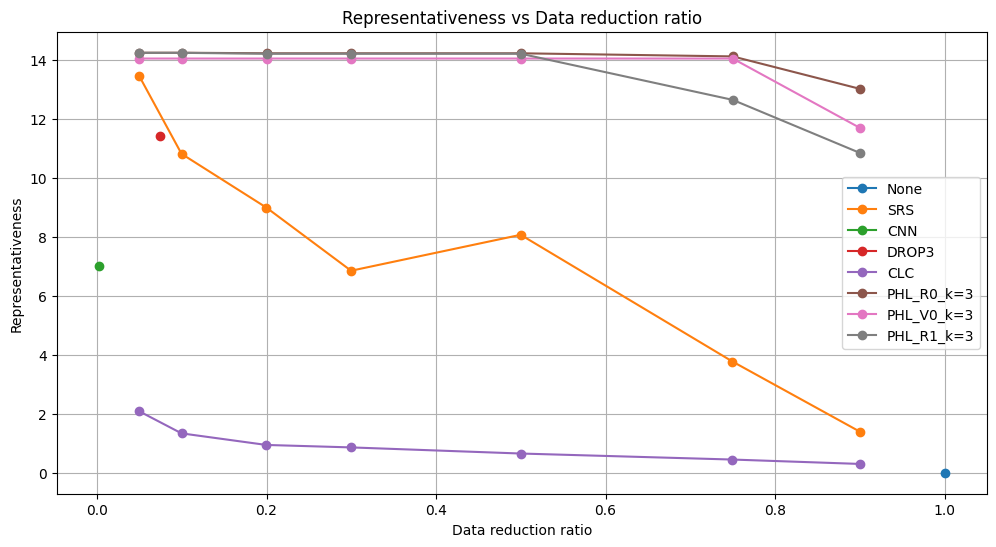

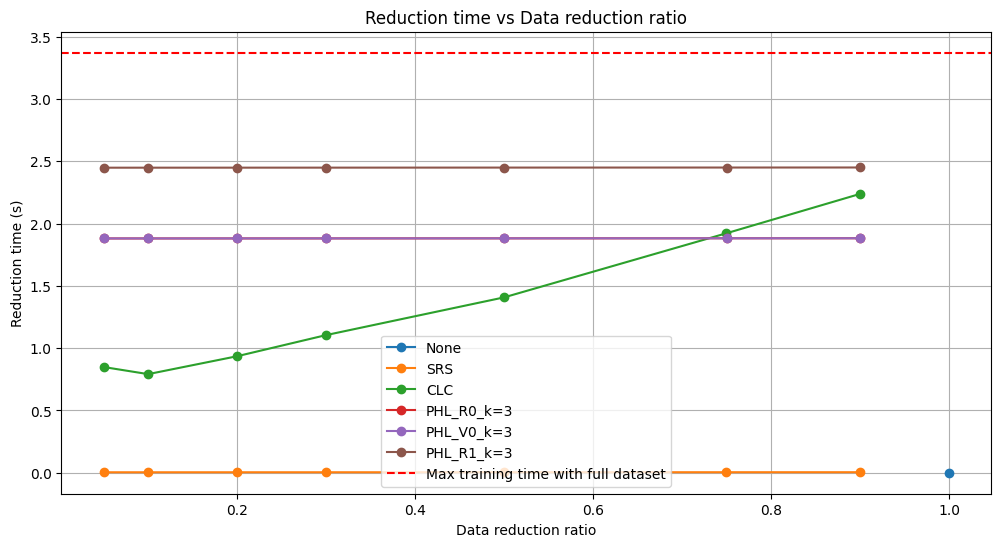

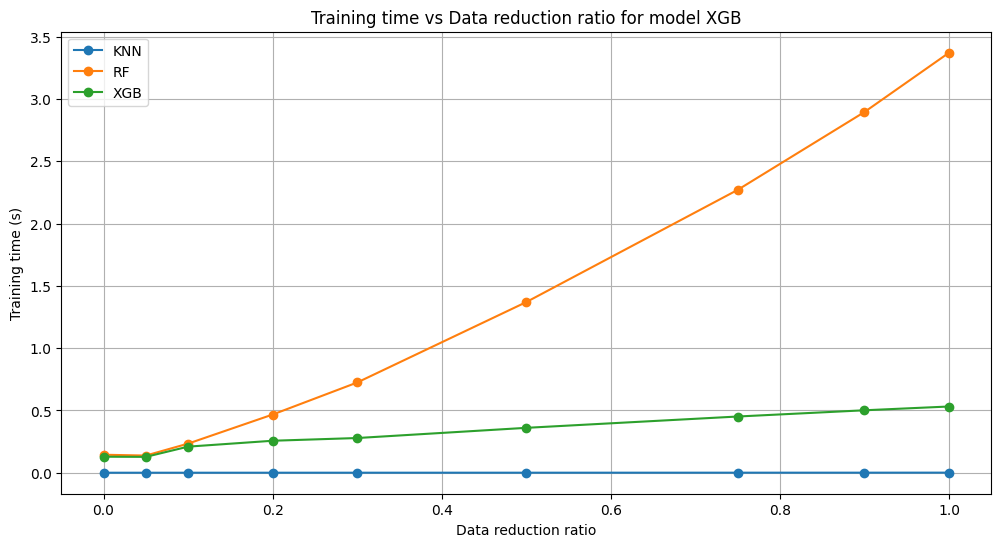

In [36]:
plot_representativeness()

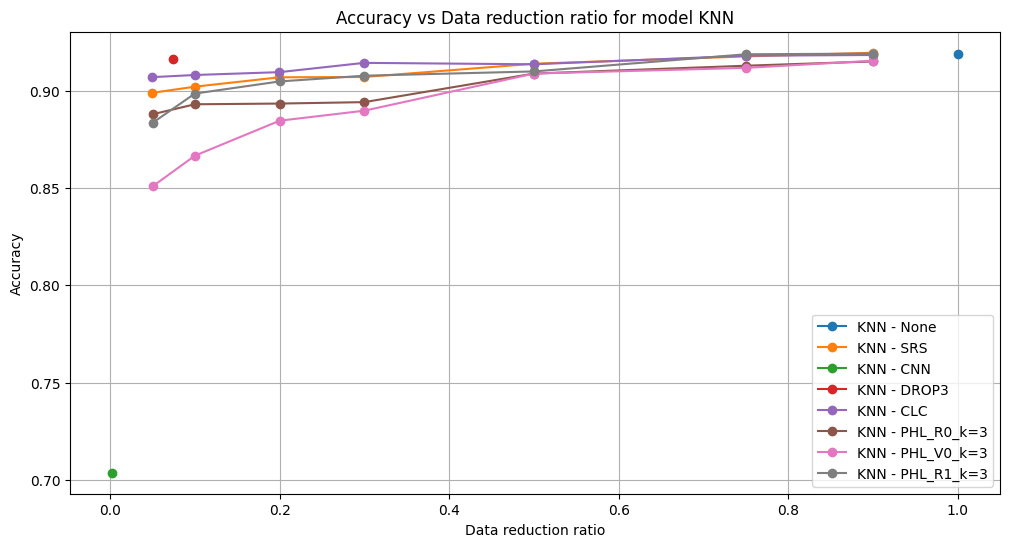

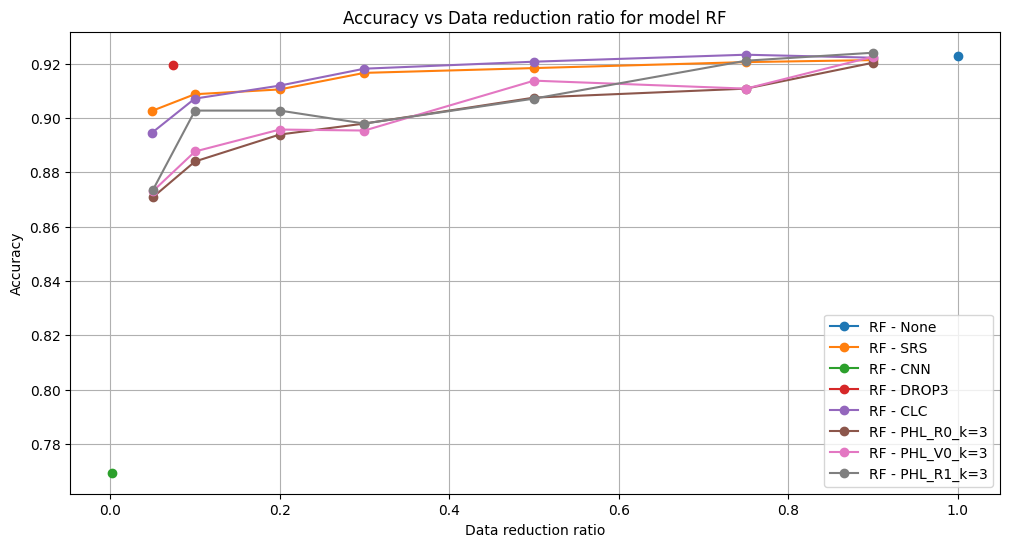

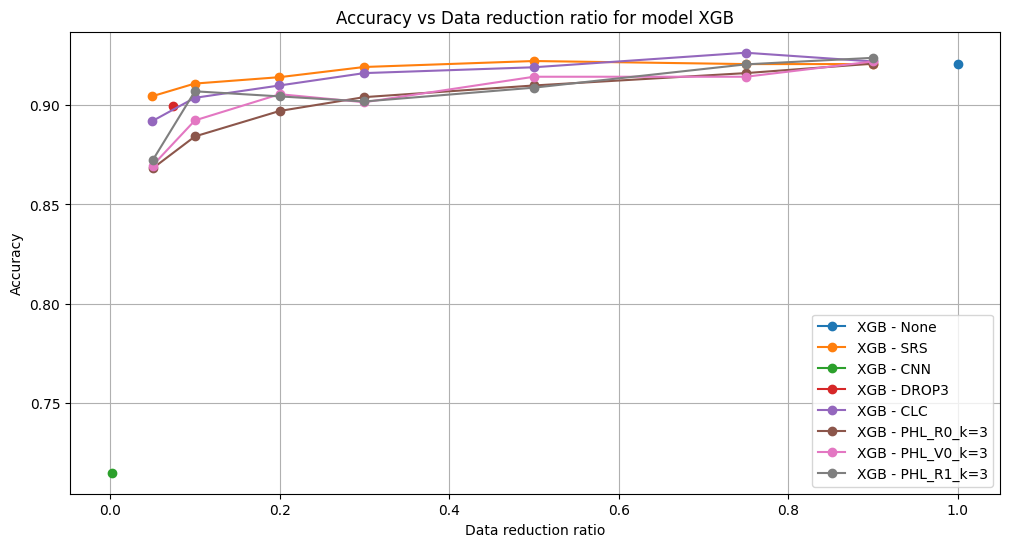

In [37]:
plot_accuracy()

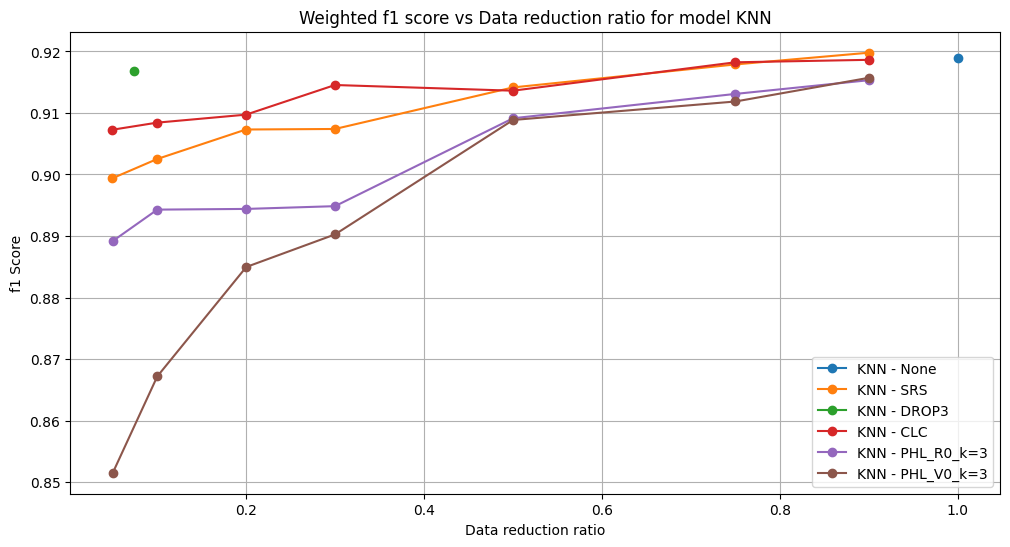

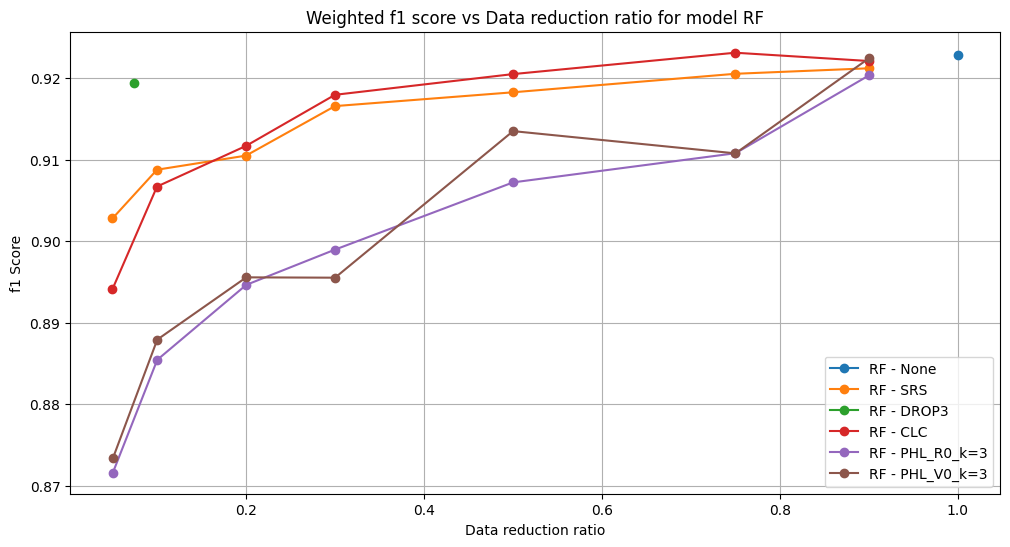

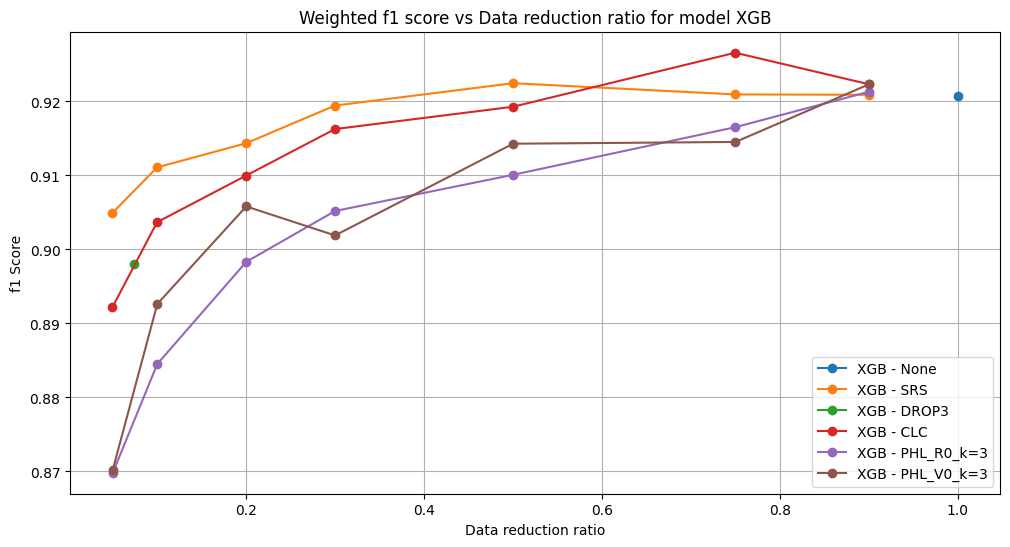

In [38]:
plot_f1()

### Dataset Diabetes binary 5050split

In [39]:
results = df_results['diabetes_binary_5050split']
results_folder = results_folders[2]
results

,model,reduction_method,percentage,reduction_ratio,representativeness,accuracy,f1,training_time,reduction_time
0,KNN,None,1.00,1.000000,0.000000,0.693472,0.693427,0.003358,0.000000
1,RF,None,1.00,1.000000,0.000000,0.741920,0.741696,4.406139,0.000000
2,XGB,None,1.00,1.000000,0.000000,0.747295,0.747000,0.146993,0.000000
3,KNN,SRS,0.05,0.049989,6.304665,0.689964,0.689944,0.000504,0.015696
4,KNN,SRS,0.10,0.099995,5.077813,0.694363,0.694333,0.000589,0.015869
...,...,...,...,...,...,...,...,...,...
103,RF,PHL_R1_k=3,0.75,0.749987,4.132581,0.737959,0.737211,2.932779,534.060951
104,XGB,PHL_R1_k=3,0.75,0.749987,4.132581,0.745031,0.744220,0.105047,534.060951
105,KNN,PHL_R1_k=3,0.90,0.900005,4.816520,0.696584,0.696504,0.002728,534.062641
106,RF,PHL_R1_k=3,0.90,0.900005,4.816520,0.741000,0.740682,3.623314,534.062641


/tmp/ipykernel_10584/2911810448.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_results = results.groupby(['reduction_method', 'percentage'])['representativeness', 'reduction_ratio', 'reduction_time'].mean().reset_index()


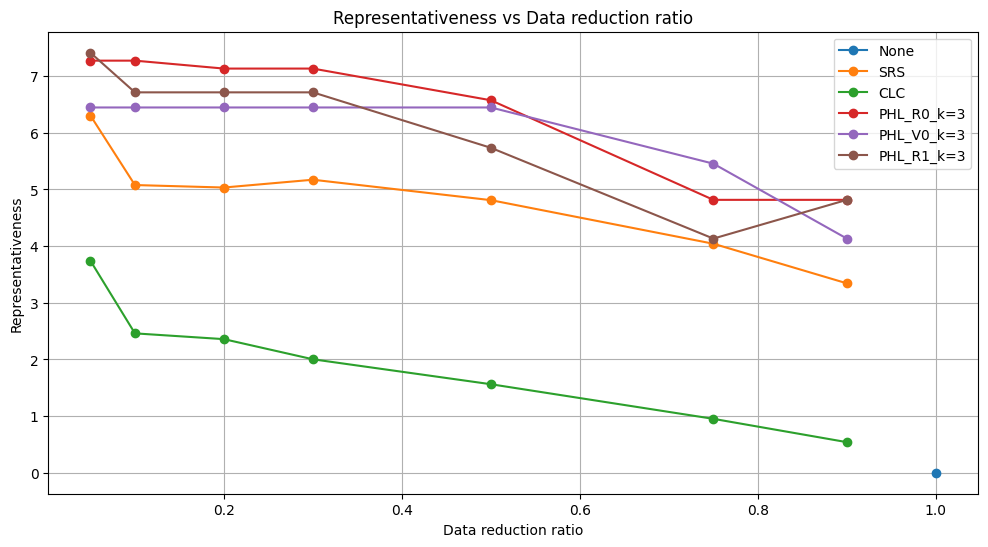

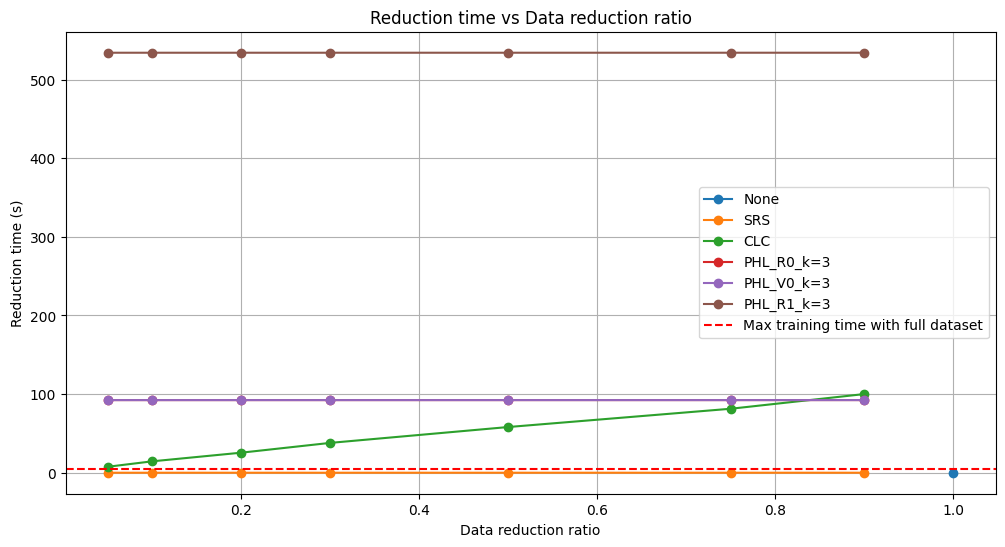

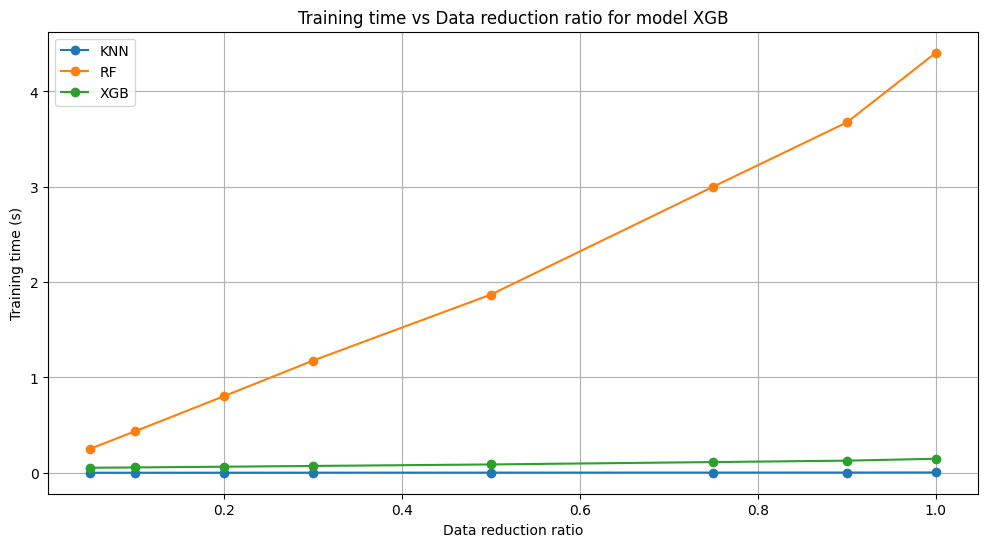

In [40]:
plot_representativeness()

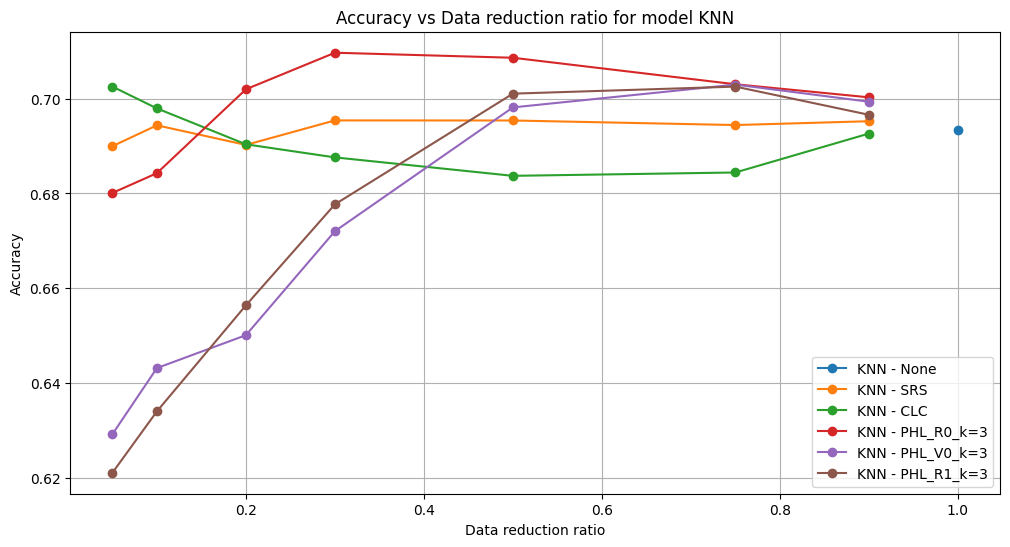

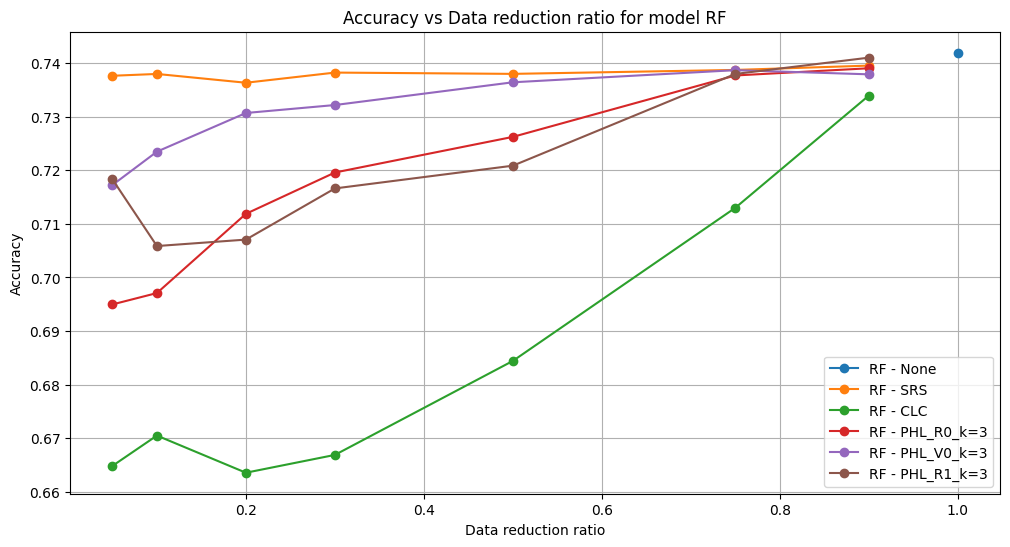

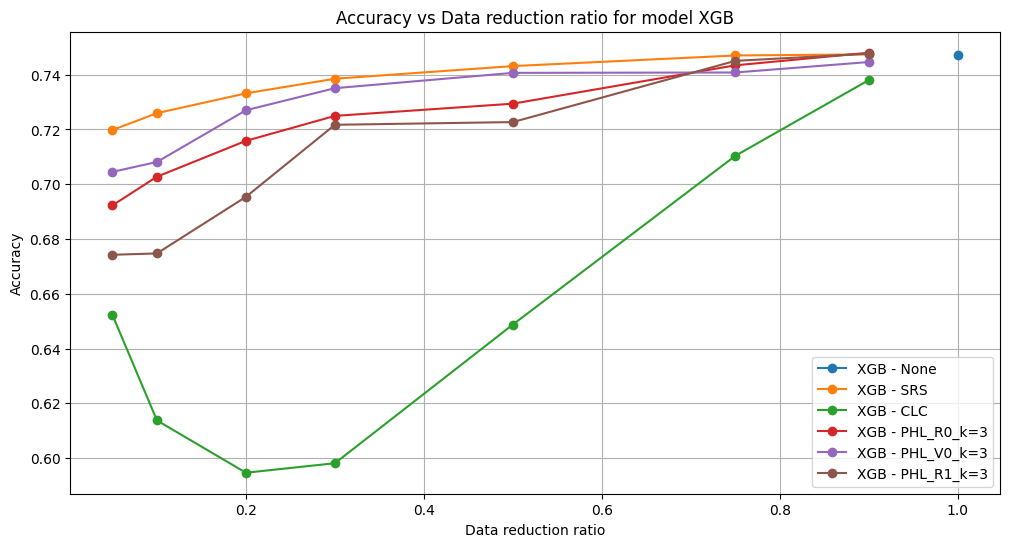

In [41]:
plot_accuracy()

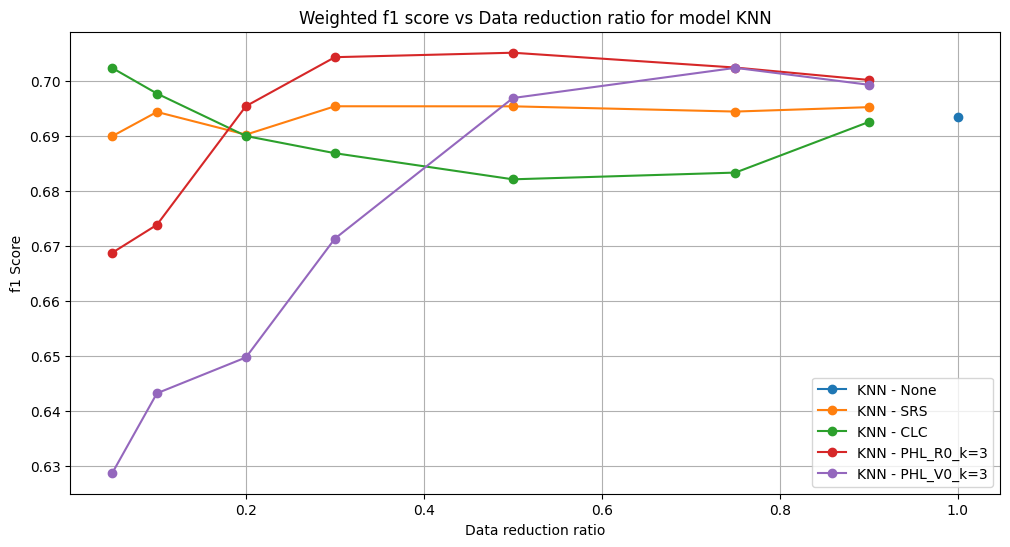

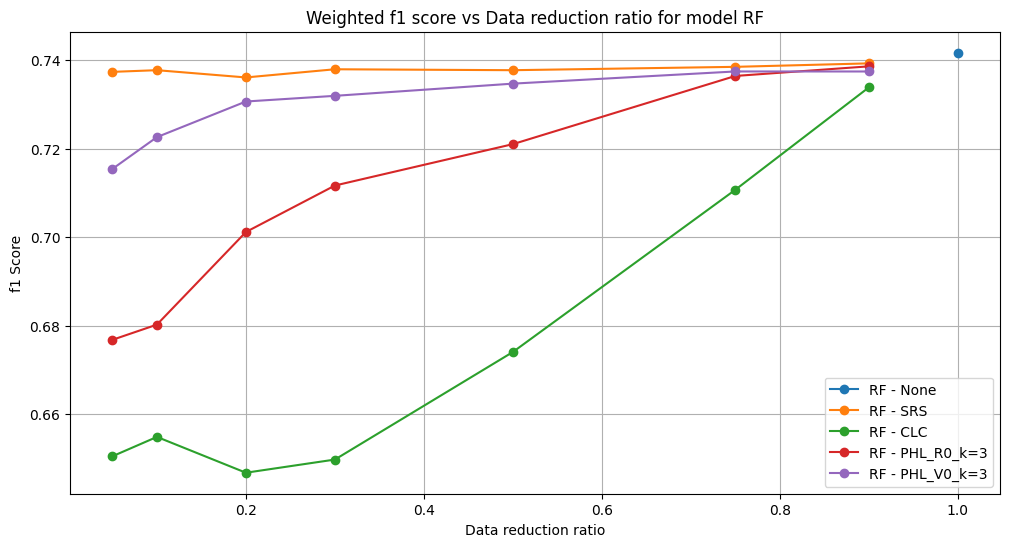

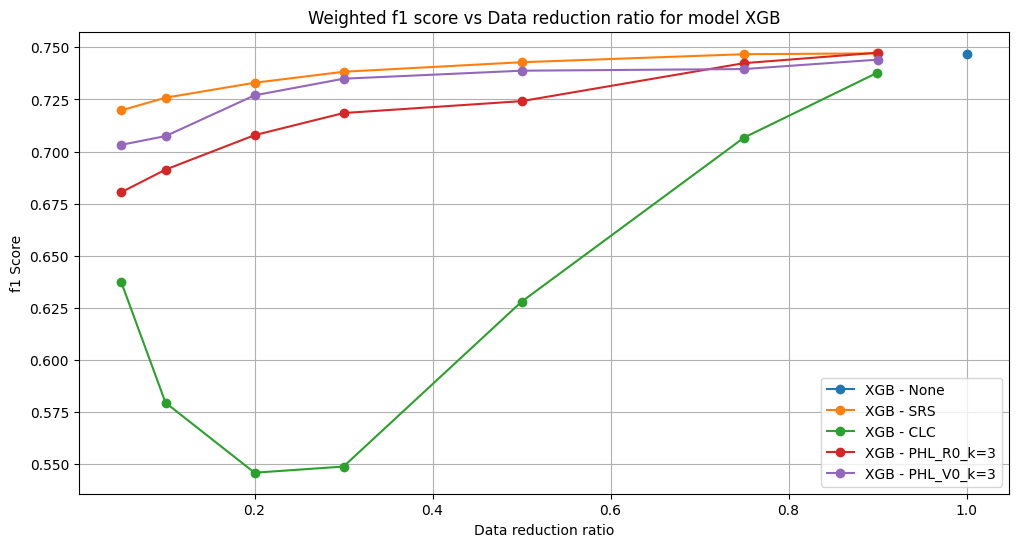

In [42]:
plot_f1()

### Dataset Diabetes binary

In [43]:
results = df_results['diabetes_binary']
results_folder = results_folders[3]
results

,model,reduction_method,percentage,reduction_ratio,representativeness,accuracy,f1,training_time,reduction_time
0,KNN,None,1.00,1.000000,0.000000,0.836112,0.822133,0.010784,0.000000
1,RF,None,1.00,1.000000,0.000000,0.860907,0.831341,18.638271,0.000000
2,XGB,None,1.00,1.000000,0.000000,0.865717,0.833687,0.450260,0.000000
3,KNN,SRS,0.05,0.049994,5.234557,0.835391,0.818343,0.000739,0.055108
4,KNN,SRS,0.10,0.099998,4.892962,0.835494,0.819705,0.001071,0.056526
...,...,...,...,...,...,...,...,...,...
103,RF,PHL_R1_k=3,0.75,0.750000,4.341922,0.856670,0.836801,11.910899,4822.431504
104,XGB,PHL_R1_k=3,0.75,0.750000,4.341922,0.862149,0.843102,0.295295,4822.431504
105,KNN,PHL_R1_k=3,0.90,0.900002,4.341922,0.835068,0.822239,0.009358,4822.438224
106,RF,PHL_R1_k=3,0.90,0.900002,4.341922,0.860020,0.833579,14.877712,4822.438224


/tmp/ipykernel_10584/2911810448.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_results = results.groupby(['reduction_method', 'percentage'])['representativeness', 'reduction_ratio', 'reduction_time'].mean().reset_index()


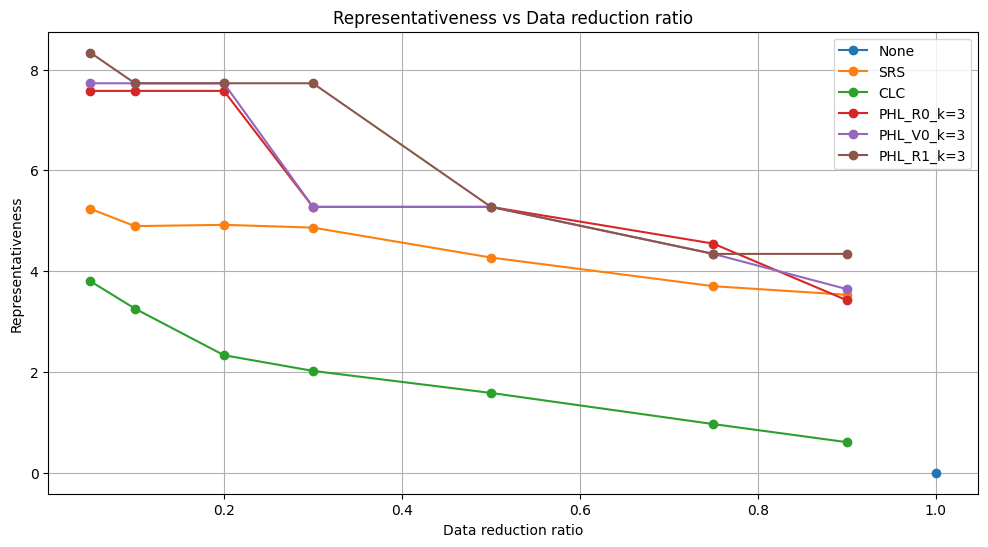

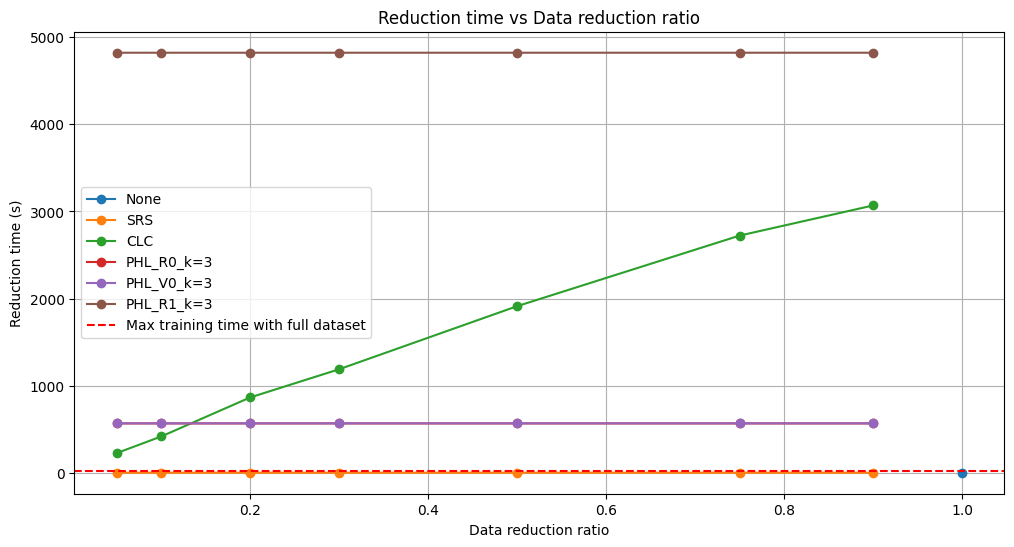

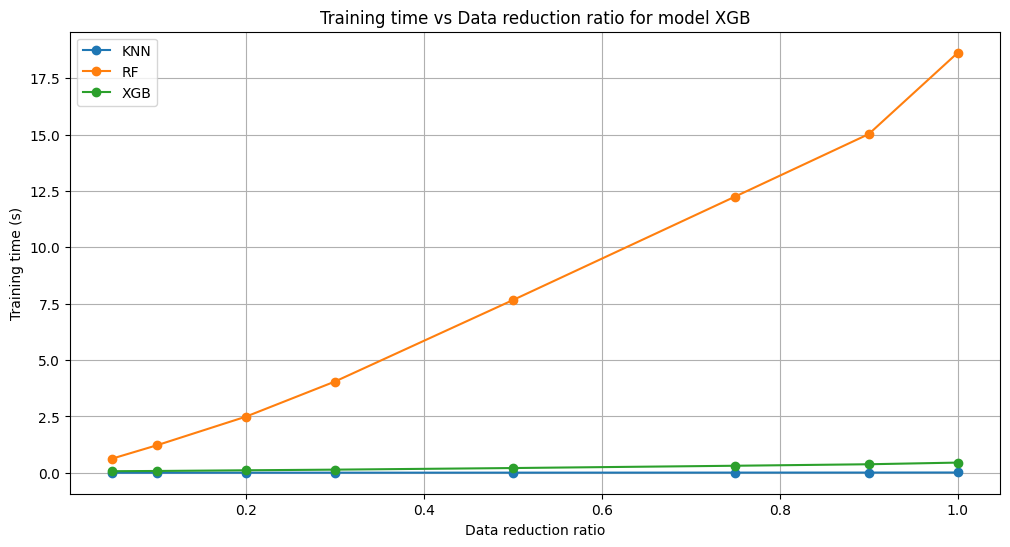

In [44]:
plot_representativeness()

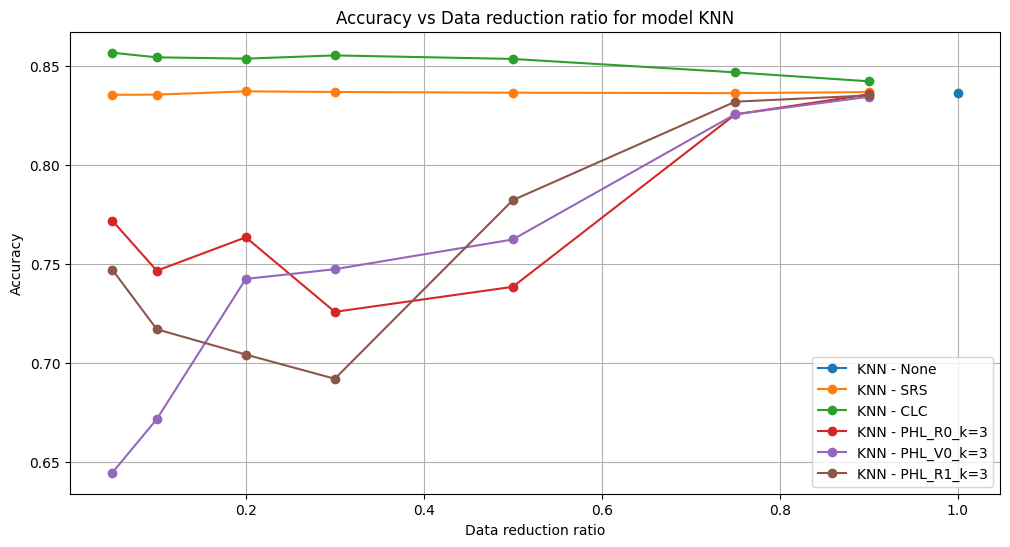

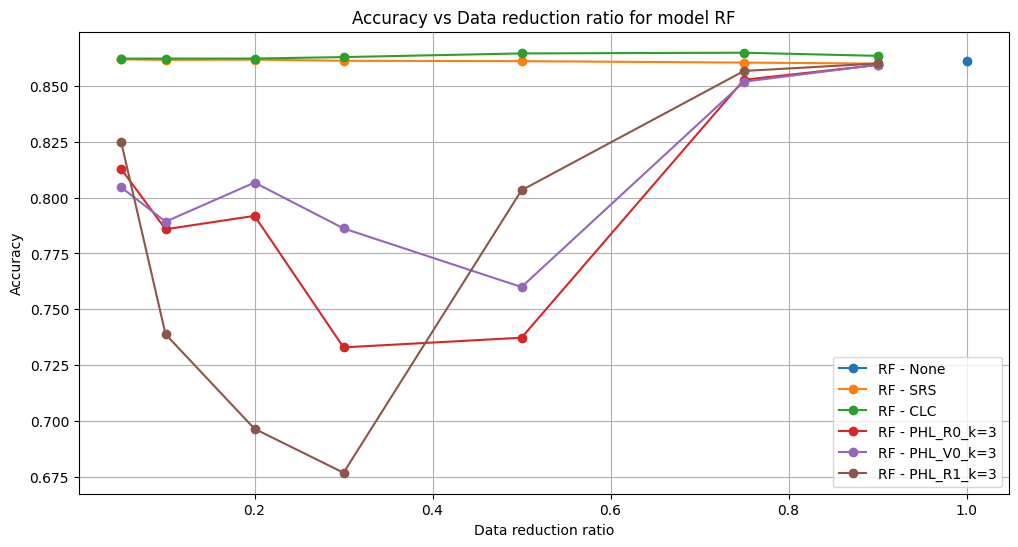

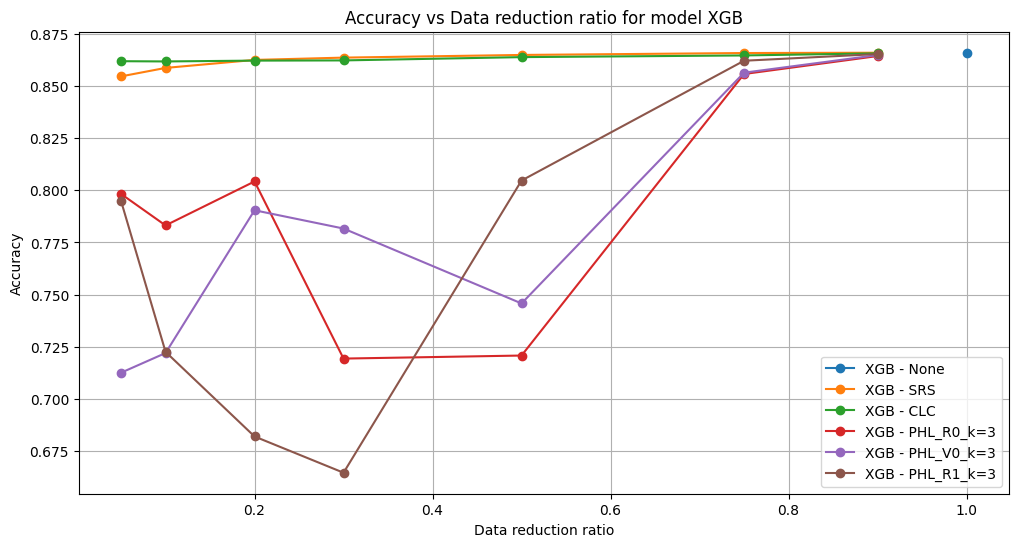

In [45]:
plot_accuracy()

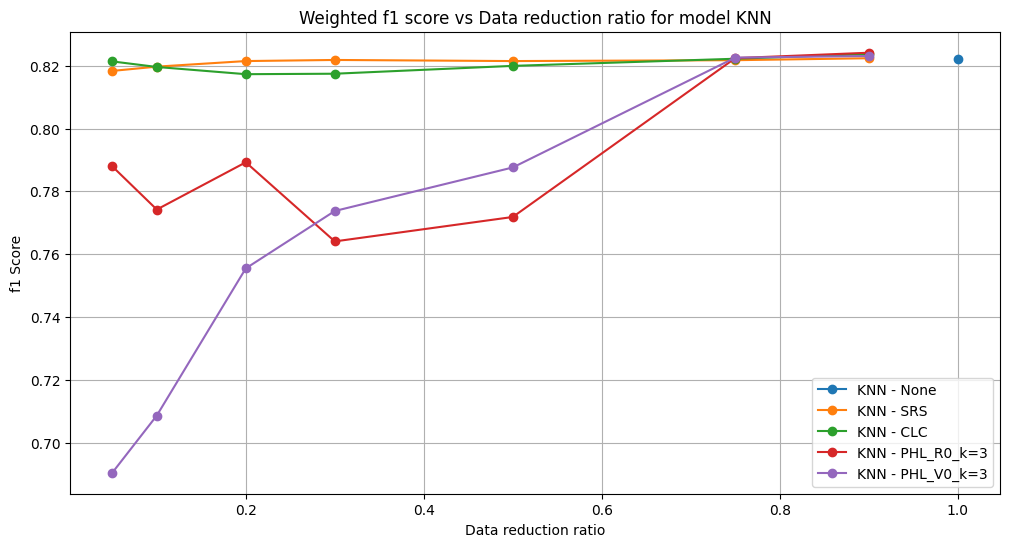

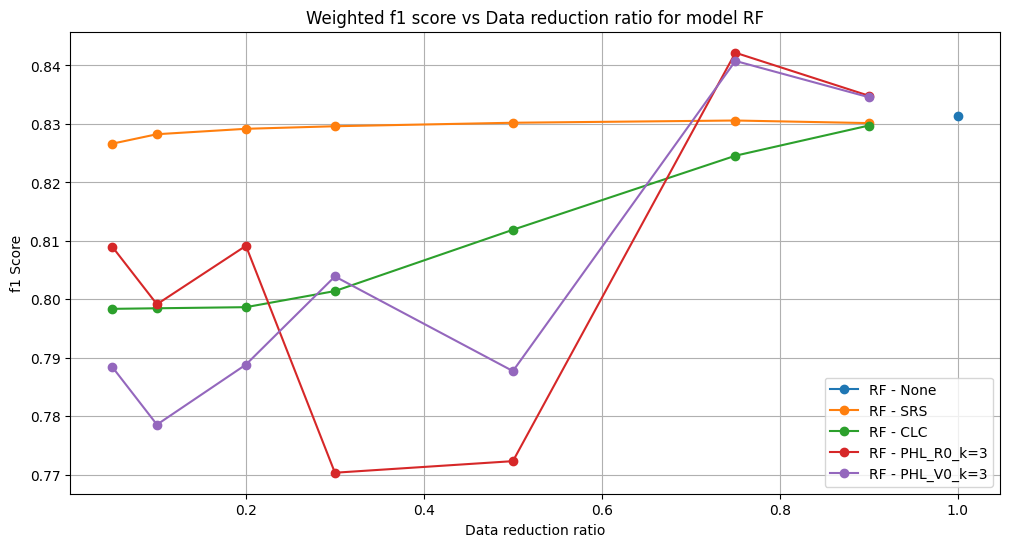

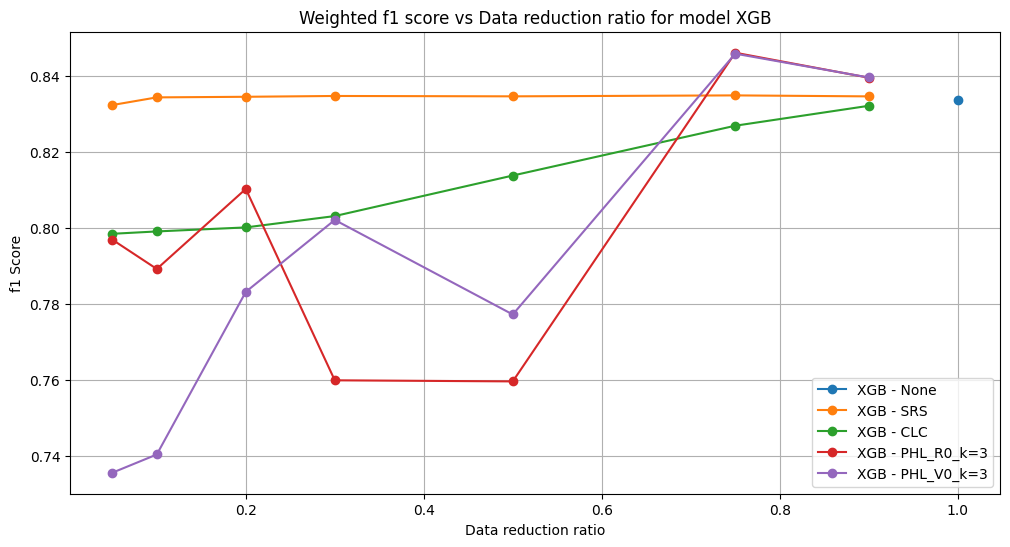

In [46]:
plot_f1()

In [47]:
# Obtain mean reduction time for each dataset for different phl methods
def mean_reduction_time():
    reduction_methods = ['PHL_R0_k=3', 'PHL_V0_k=3', 'PHL_R1_k=3']
    mean_times = {}
    
    for dbname, results in df_results.items():
        mean_times[dbname] = {}
        for method in reduction_methods:
            if method in results['reduction_method'].values:
                mean_time = results[results['reduction_method'] == method]['reduction_time'].mean()
                mean_times[dbname][method] = mean_time
            else:
                mean_times[dbname][method] = None
    
    return pd.DataFrame(mean_times)
mean_times_df = mean_reduction_time()

In [48]:
for row in mean_times_df.iterrows():
    print(f"{row[0]}: {row[1]}")

PHL_R0_k=3: pima                           0.090577
drybeans                       1.880944
diabetes_binary_5050split     92.365246
diabetes_binary              566.392092
Name: PHL_R0_k=3, dtype: float64
PHL_V0_k=3: pima                           0.090572
drybeans                       1.880949
diabetes_binary_5050split     92.365195
diabetes_binary              566.390227
Name: PHL_V0_k=3, dtype: float64
PHL_R1_k=3: pima                            0.130903
drybeans                        2.448902
diabetes_binary_5050split     534.057903
diabetes_binary              4822.416620
Name: PHL_R1_k=3, dtype: float64


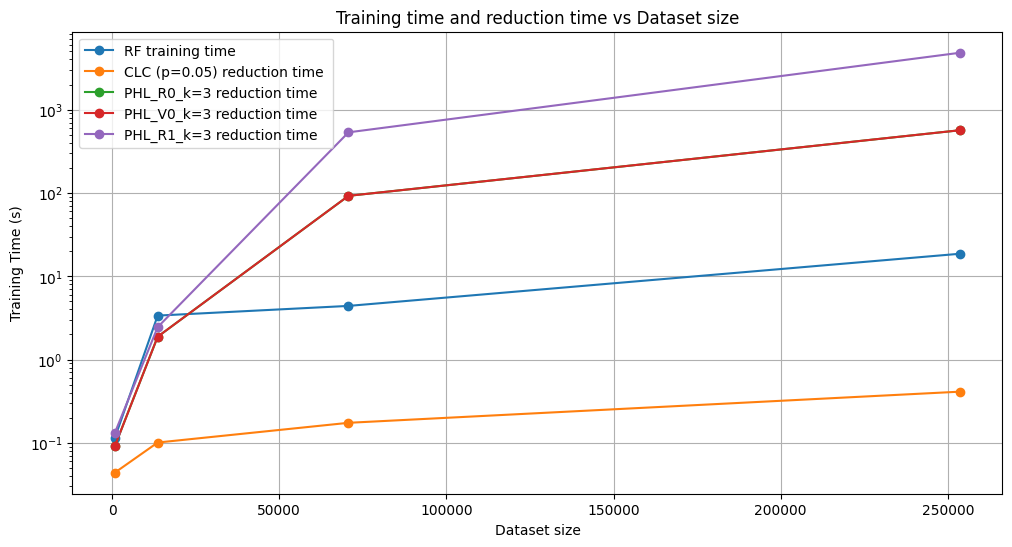

In [49]:
# Plot random forest training time with different full datasets from the results dataframes
def plot_rf_training_time():
    plt.figure(figsize=(12, 6))
    dataset_sizes = [df.shape[0] for df in dfs]
    rf_training_times = [
        df_results[dbname][(df_results[dbname]['model'] == 'RF') & (df_results[dbname]['reduction_method'] == 'None')]['training_time'].values[0]
        for dbname, df in zip(dbnames, dfs)
    ]
    clc_reduction_times = [
        df_results[dbname][(df_results[dbname]['reduction_method'] == 'CLC') & (df_results[dbname]['percentage'] == 0.05)]['training_time'].mean()
        for dbname, df in zip(dbnames, dfs)
    ]
    plt.plot(dataset_sizes, rf_training_times, label='RF training time', marker='o')
    plt.plot(dataset_sizes, clc_reduction_times, label='CLC (p=0.05) reduction time ', marker='o')
    for row in mean_times_df.iterrows():
        plt.plot(dataset_sizes, row[1].values, label=f'{row[0]} reduction time', marker='o')
    plt.title('Training time and reduction time vs Dataset size')
    plt.xlabel('Dataset size')
    plt.ylabel('Training Time (s)')
    plt.legend()
    plt.grid()
    plt.yscale('log')
    # plt.savefig(f'{results_folder}/rf_training_time_vs_reduction_ratio.png')
    plt.show()
plot_rf_training_time()